In [ ]:
import numpy as np
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import lulc_in_zrange # A set of utilities we developed! 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import pygeohydro as gh

# elev_fname = '../data/ubrb_dem_30m.tif'
# lulc_fname = '../data/upper_boise_landcover_30m.tif'
elev_fname = '../data/hfork_ws_dem_30m.tif'
lulc_fname = '../data/hfork_ws_lulc_30m.tif'

nlcd_cfile = './nlcd_classifications.csv'

delta_z = 100.0

In [34]:
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1)

zmin = np.nanmin(elev_array)
zmax = np.nanmax(elev_array)
zmean = np.nanmax(elev_array)

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {elev_array.shape[1]} 
Number of rows [north-south]: {elev_array.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''

print(zstats)


Elevation Statistics:
Number of columns [east-west]: 9784 
Number of rows [north-south]: 8468
Minimum elevation: 1432.38 m
Maximum elevation: 4187.97 m
Mean elevation: 4187.97 m



In [35]:
lulc_data = rio.open(lulc_fname)
lulc_array = np.flipud(lulc_data.read(1))
lulc_array = lulc_array.astype('float')
lulc_array[lulc_array==0] = np.nan
lulc_bins = np.unique(lulc_array[~np.isnan(lulc_array)])

lulcstats = f'''
Land Use/Land Cover Present: {lulc_bins}
'''

print(lulcstats)


Land Use/Land Cover Present: [11. 12. 21. 22. 23. 24. 31. 41. 42. 43. 52. 71. 81. 82. 90. 95.]



In [36]:
z_bot = np.floor(zmin/delta_z)*delta_z
z_top = np.ceil(zmax/delta_z)*delta_z

In [37]:
z_intervals = np.arange(z_bot, z_top+delta_z, delta_z)

In [38]:
nz = z_intervals.size
nlulc = lulc_bins.size

LULCxZfracs = np.zeros((nz-1,nlulc))
Zfracs = np.zeros((nz-1))

for i in np.arange(nz-1):
    ranges = f'''
    Interval: {i}
    Bottom elevation: {z_intervals[i]:.{2}f}
    Top interval: {z_intervals[i+1]:.{2}f}
    '''
    print(ranges)
    
    lulc_dz = lulc_in_zrange.lulc_in_zrange(lulc_array, lulc_bins, elev_array, z_intervals[i], z_intervals[i+1])
    
    lulc_fracs_dz = lulc_dz/lulc_dz.sum()
    
    Zfracs[i] = lulc_dz.sum()/elev_array.size
    LULCxZfracs[i,:] = lulc_fracs_dz
    


    Interval: 0
    Bottom elevation: 1250.00
    Top interval: 1500.00
    

    Interval: 1
    Bottom elevation: 1500.00
    Top interval: 1750.00
    

    Interval: 2
    Bottom elevation: 1750.00
    Top interval: 2000.00
    

    Interval: 3
    Bottom elevation: 2000.00
    Top interval: 2250.00
    

    Interval: 4
    Bottom elevation: 2250.00
    Top interval: 2500.00
    

    Interval: 5
    Bottom elevation: 2500.00
    Top interval: 2750.00
    

    Interval: 6
    Bottom elevation: 2750.00
    Top interval: 3000.00
    

    Interval: 7
    Bottom elevation: 3000.00
    Top interval: 3250.00
    

    Interval: 8
    Bottom elevation: 3250.00
    Top interval: 3500.00
    

    Interval: 9
    Bottom elevation: 3500.00
    Top interval: 3750.00
    

    Interval: 10
    Bottom elevation: 3750.00
    Top interval: 4000.00
    

    Interval: 11
    Bottom elevation: 4000.00
    Top interval: 4250.00
    


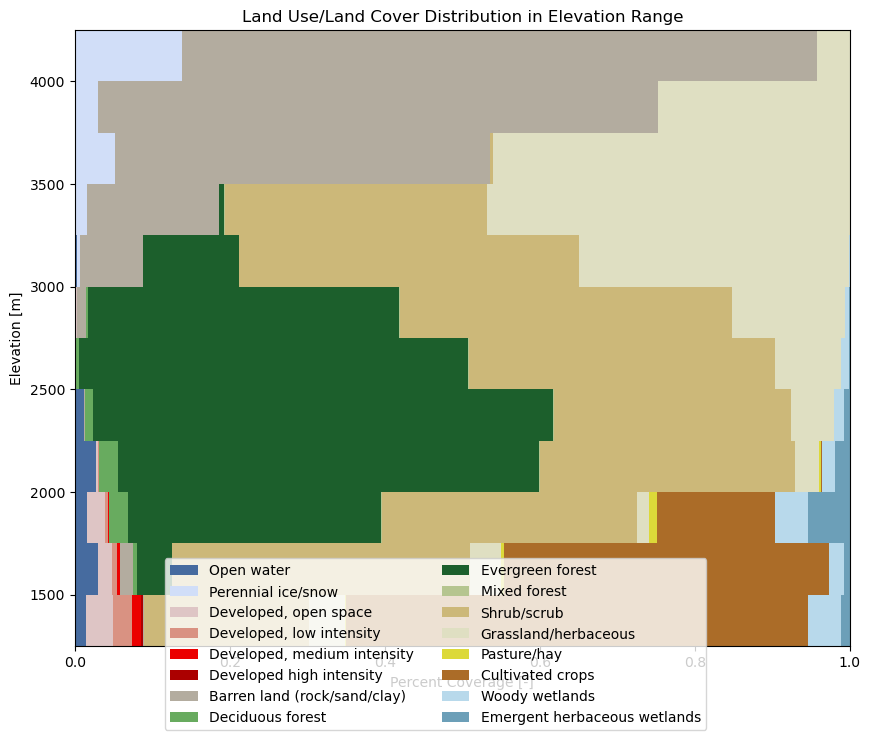

In [39]:
# Create NLCD colormap 
nlcd_df = pd.read_csv(nlcd_cfile)
cmap_nlcd = mcolors.ListedColormap(nlcd_df.color_code.values.astype(str),'nlcd_cmap')
norm_nlcd = mcolors.BoundaryNorm(lulc_bins, cmap_nlcd.N)

fig, ax = plt.subplots(figsize=(10,8))

left = np.zeros((nz-1))

z_plot = z_intervals[:-1]+delta_z/2

for i in np.arange(lulc_bins.size):
    lulc_fracs = LULCxZfracs[:,i]
    ax.barh(z_plot, lulc_fracs, left=left, 
            height=delta_z, color=cmap_nlcd.colors[i], 
            label=nlcd_df.label_short.values[i])
    left += LULCxZfracs[:,i]

ax.set_ylim([z_intervals[0],z_intervals[-1]])
ax.set_xlim([0,1])
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Percent Coverage [-]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('Elevation [m]')
fig.legend(fontsize=10, ncol=2, loc='outside lower center')
plt.show()

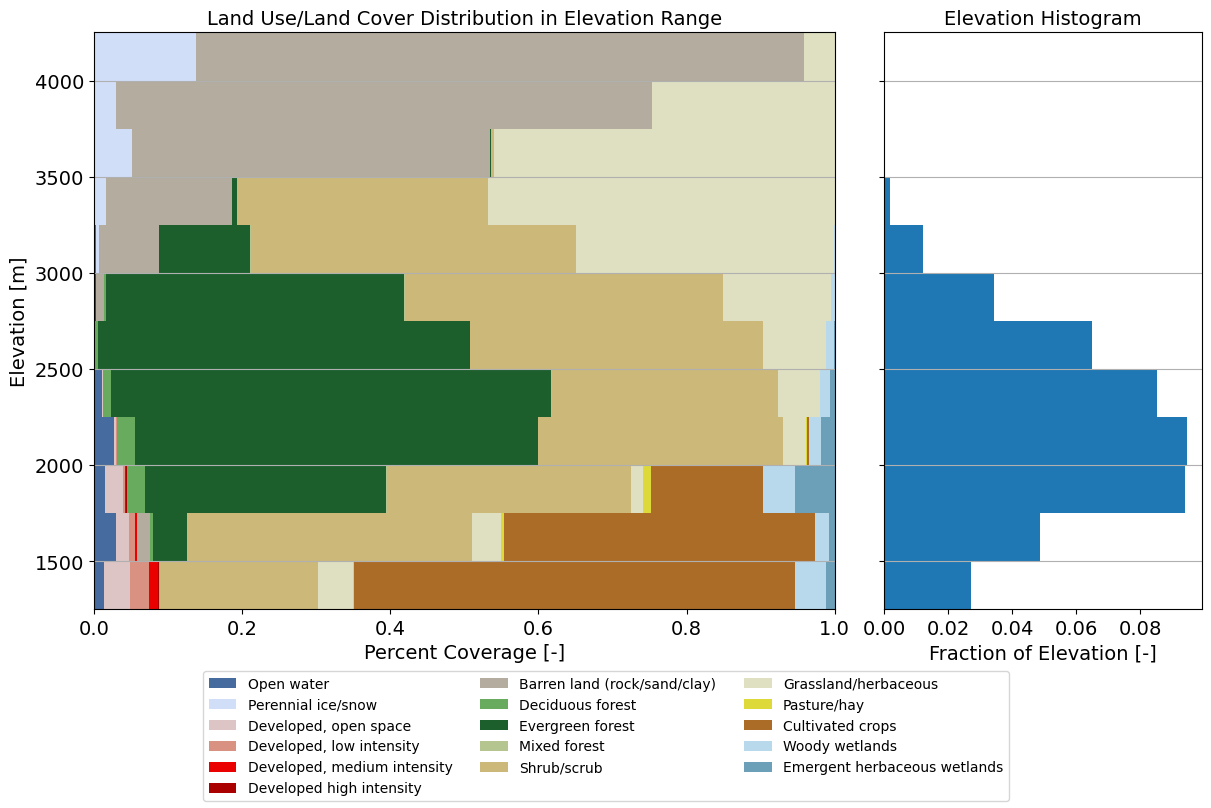

In [40]:
fig, axs = plt.subplot_mosaic([['left','right']], layout='constrained', figsize=(12,8), width_ratios=[0.7, 0.3])

left = np.zeros((nz-1))

z_plot = z_intervals[:-1]+delta_z/2

for i in np.arange(lulc_bins.size):
    lulc_fracs = LULCxZfracs[:,i]
    axs['left'].barh(z_plot, lulc_fracs, left=left, 
            height=delta_z, color=cmap_nlcd.colors[i], 
            label=nlcd_df.label_short.values[i])
    left += LULCxZfracs[:,i]

axs['left'].set_ylim([z_intervals[0],z_intervals[-1]])
axs['left'].set_xlim([0,1])
axs['left'].set_title('Land Use/Land Cover Distribution in Elevation Range',fontsize=14)
axs['left'].set_xlabel('Percent Coverage [-]',fontsize=14)
axs['left'].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs['left'].set_ylabel('Elevation [m]',fontsize=14)
axs['left'].grid('on', which='major', axis='y')
axs['left'].tick_params(axis='both', which='major', labelsize=14)

axs['right'].barh(z_plot,Zfracs, height=delta_z)
axs['right'].set_ylim([z_intervals[0],z_intervals[-1]])
axs['right'].set_title('Elevation Histogram',fontsize=14)
axs['right'].set_xlabel('Fraction of Elevation [-]',fontsize=14)
axs['right'].set_ylabel('') 
axs['right'].grid('on', which='major', axis='y')
axs['right'].set_yticklabels([])
axs['right'].tick_params(axis='both', which='major', labelsize=14)

fig.legend(fontsize=10, ncol=3, loc='outside lower center')

plt.show()